In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2022-05-09 18:50:10.878258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
file_name = "QoE_Linear_TrainingSet.csv"
df = pd.read_csv ('QoE_Linear_TrainingSet.csv')
df.head(3)


,session,rtt,download_lossrate,download_throughput,Stalling_number,Stalling_length,join_time,QoE_linear
0,1,993,0.07,5217,2,27968,26522,2
1,1,933,0.04,5198,3,5925,20380,3
2,1,873,0.00,5179,1,849,11620,4


In [4]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[::1] 


print(df)


      session   rtt  download_lossrate  download_throughput  Stalling_number  \
0           1   993               0.07                 5217                2   
1           1   933               0.04                 5198                3   
2           1   873               0.00                 5179                1   
3           1   813               0.04                 5160                1   
4           1   753               0.07                 5141                1   
...       ...   ...                ...                  ...              ...   
9569        5  4560               0.21                 8681             1000   
9570        5  4410               0.14                 8661             1000   
9571        5  4260               0.08                 8641             1000   
9572        5  4110               0.02                 8621                2   
9573        5  3960               0.04                 8601                2   

      Stalling_length  join_time  QoE_l

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
session,9574.0,3.343430,1.372104,1.0,2.00,4.00,4.00,5.00
rtt,9574.0,2380.539377,1457.249216,2.0,1110.00,2290.00,3641.50,4992.00
download_lossrate,9574.0,0.120053,0.071802,0.0,0.06,0.12,0.18,0.25
download_throughput,9574.0,4982.315960,2878.284443,0.0,2479.25,4948.00,7450.00,10000.00
Stalling_number,9574.0,314.993211,457.094995,0.0,2.00,2.00,1000.00,1000.00
Stalling_length,9574.0,141159.370796,174035.257457,0.0,10865.25,34550.00,400000.00,400000.00
join_time,9574.0,189931.508043,165904.818240,1322.0,43546.25,100769.00,400000.00,400000.00
QoE_linear,9574.0,1.534155,1.060990,1.0,1.00,1.00,1.00,5.00


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}



n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(column_indices)

{'session': 0, 'rtt': 1, 'download_lossrate': 2, 'download_throughput': 3, 'Stalling_number': 4, 'Stalling_length': 5, 'join_time': 6, 'QoE_linear': 7}


In [7]:
fft = tf.signal.rfft(df['QoE_linear'])


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print(column_indices)

{'session': 0, 'rtt': 1, 'download_lossrate': 2, 'download_throughput': 3, 'Stalling_number': 4, 'Stalling_length': 5, 'join_time': 6, 'QoE_linear': 7}


In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

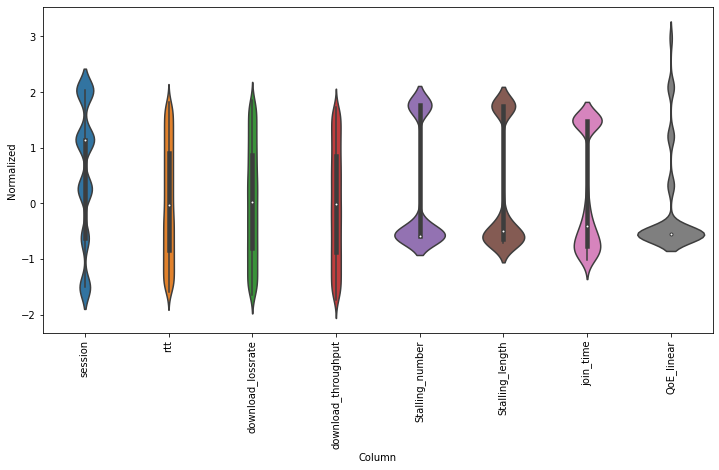

In [10]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [11]:
# In the original dataset "4" indicates the pet was not adopted.
df['target'] = df['QoE_linear']

df = df.drop(columns=['QoE_linear','join_time'])

In [12]:
print(df.shape)

(9574, 7)


In [13]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

6127 train examples
1532 validation examples
1915 test examples


In [14]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [15]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [16]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of rtt:', feature_batch['session'])
  print('A batch of targets:', label_batch )

Every feature: ['session', 'rtt', 'download_lossrate', 'download_throughput', 'Stalling_number', 'Stalling_length']
A batch of rtt: tf.Tensor([1 2 5 2 3], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 3 1], shape=(5,), dtype=int64)


In [17]:
example_batch = next(iter(train_ds))[0]

In [18]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [19]:
photo_count = feature_column.numeric_column('download_lossrate')
demo(photo_count)

[[0.21]
 [0.05]
 [0.06]
 [0.14]
 [0.17]]


In [20]:
qoe = feature_column.numeric_column('session')
qoe_buckets = feature_column.bucketized_column(qoe, boundaries=[1, 2,3,4,5])
demo(qoe_buckets)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [21]:
# Notice the input to the embedding column is the categorical column
# we previously created
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'session', df.download_throughput.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.38774136 -0.42298362 -0.5965022   0.08010495 -0.49206373  0.31878415
  -0.6275102   0.41390383]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]


In [22]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Stalling_number', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))



ValueError: Exception encountered when calling layer "dense_features_3" (type DenseFeatures).

Column dtype and SparseTensors dtype must be compatible. key: Stalling_number, column dtype: <dtype: 'string'>, tensor dtype: <dtype: 'int64'>

Call arguments received by layer "dense_features_3" (type DenseFeatures):
  • features={'session': 'tf.Tensor(shape=(5,), dtype=int64)', 'rtt': 'tf.Tensor(shape=(5,), dtype=int64)', 'download_lossrate': 'tf.Tensor(shape=(5,), dtype=float32)', 'download_throughput': 'tf.Tensor(shape=(5,), dtype=int64)', 'Stalling_number': 'tf.Tensor(shape=(5,), dtype=int64)', 'Stalling_length': 'tf.Tensor(shape=(5,), dtype=int64)'}
  • cols_to_output_tensors=None
  • training=False

In [23]:
example_batch = next(iter(train_ds))[0]

In [24]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())


In [25]:
photo_count = feature_column.numeric_column('session')
demo(photo_count)

[[5.]
 [4.]
 [3.]
 [1.]
 [5.]]


In [26]:
feature_columns = []
# numeric cols
for header in ['rtt', 'download_lossrate', 'download_throughput']:
  feature_columns.append(feature_column.numeric_column(header))

In [27]:
age = feature_column.numeric_column('rtt')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

In [28]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [29]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [30]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
192/192 [==============================] - 2s 4ms/step - loss: -109646.9453 - accuracy: 0.7526 - val_loss: -471839.1250 - val_accuracy: 0.7604
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: -1988578.1250 - accuracy: 0.7542 - val_loss: -4658030.5000 - val_accuracy: 0.7604
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: -9739753.0000 - accuracy: 0.7542 - val_loss: -16903952.0000 - val_accuracy: 0.7604
Epoch 4/10
192/192 [==============================] - 0s 2ms/step - loss: -27277820.0000 - accuracy: 0.7542 - val_loss: -40799852.0000 - val_accuracy: 0.7604
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: -57538608.0000 - accuracy: 0.7542 - val_loss: -78798800.0000 - val_accuracy: 0.7604
Epoch 6/10
192/192 [==============================] - 1s 2ms/step - loss: -102402296.0000 - accuracy: 0.7542 - val_loss: -132452960.0000 - val_accuracy: 0.7604
Epoch 7/10
192/192 [==============================] - 1s 

In [31]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

60/60 [==============================] - 0s 2ms/step - loss: -523186368.0000 - accuracy: 0.7645
Accuracy 0.7644908428192139
